# Métodos de Diferencias Temporales (TD)

En este notebook vamos a ver métodos de diferencias temporales en particular, vamos a ver un método de control on-policy (Sarsa) y un método off-policy (Q-Learning) para estimar la funcion de valor (y la política) ótima para un problema. 


El notebook se basa en el capítulo 6 del libro de Sutton y Barto.


****

## Ambiente

Vamos a utilizar un problema clásico de Reinforcement Learning, y para ello vamos a usar otro ambiente de OpenAi gym: MountainCar: https://gym.openai.com/envs/MountainCar-v0/.

La descripcion del mismo es la siguiente:

Un auto esta posicionado en un carril de una dimension entre dos montañas. El objetivo es llegar a la cima de la montaña derecha pero, el motor del auto no es lo suficientemente fuerte para hacerlo en una sola pasada (no puede simplemente acelerar y llegar). Entonces, la única forma de tener éxito es ir de atrás hacia delante repetidas veces para acumular suficiente energía para subir.

![Image](https://i.ytimg.com/vi/slIJHOuTCmc/hqdefault.jpg)

Este ambiente tiene representación gráfica visual en gym, para ello vamos a hacer uso de unas funciones auxliares para poder ver resultados en video en colab.


****

## A entregar:

- Implementación de algoritmo Q-Learning
- Implementacion de algoritmo Sarsa
- Comparacion entre ambos para el ambiente dado, cuanto tarda cada uno en llegar al objetivo (en promedio). 





### Funciones auxiliares para visualizar el ambiente

In [ ]:
# Dependencias necesarias.
!pip install gym==0.15.3 pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
# Imports y funciones para ver el ambiente.
import io
import gym
import glob
import base64
from gym.wrappers import Monitor
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay


display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  """
  Utility function to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)""
  """
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  """
  Wrapper del ambiente donde definimos un Monitor que guarda la visualizacion como un archivo de video.
  """
  
  env = Monitor(env, './video', force=True)
  return env

### Creación del ambiente y visualizacion de un agente aleatorio.



In [ ]:
# Necesitamos "envolver" el ambiente para hacer uso de las funciones definidas anteriormente.
env = wrap_env(gym.make("MountainCar-v0"))

# El resto del código es igual a lo que venimos acostumbrados.
observation = env.reset()

while True:
    env.render()  # Queremos poder ver el ambiente. 

    action = env.action_space.sample() 
    observation, reward, done, info = env.step(action) 
        
    if done:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env

### Interacción con el ambiente

El ambiente cuenta con 3 acciones: Acelerar a la izquierda, frenar y acelerar a la derecha. Las recompensas son -1 por cada accion tomada con excepcion de llegar a la cima de la montaña. Un episodio se termina al alcanzar la cima o al luego de 200 interacciones.

Lo que podemos observar al interactuar con el es un valor real para su Velocidad (negativa al ir para la izquierda, positiva a la derecha) y un valor real para su Posicion en la línea.

Ambos valores son continuos, esto nos representa un problema, ya que queremos modelar una función de valor y una política para todos los estados posibles.

Para atacar este problema vamos a **DISCRETIZAR** el ambiente, esto es: convertir la posicion y velocidad del auto en valores discretos dentro de un rango definido.

Para ello vamos a definir algunas constantes y una función que nos permite obtener una representacion discreta de las observaciones del ambiente.


In [ ]:
import numpy as np

# Vamos a utilizar 40x40 estados para representar todas las combinaciones de posicion y velocidad.
NUMBER_STATES = 40

def discretization(env, obs):
    # observation_space low y high nos permiten conocer los límites de nuestro ambiente para los valores de Posicion y Velocidad.
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    
    env_den = (env_high - env_low) / NUMBER_STATES
    pos_den = env_den[0]
    vel_den = env_den[1]
    
    pos_low = env_low[0]
    vel_low = env_low[1]
    
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    
    return pos_scaled, vel_scaled

Una vez tenemos el ambiente discretizado, podemos crear una tabla que contenga el valor esperado para cada estado posible (donde en este caso, cada estado es una terna de: posicion, velocidad y accion a tomar). 

Esta tabla es normalmente conocida como "Q table" por su uso en Q learning (aunque tambien se usa, pero de manera distinta en Sarsa).

### Q-Learning

Vamos a comenzar implementando Q-learning para el problema actual, la implementacion corre por parte de los estudiantes.

Recordamos aquí el algoritmo:

![Image](https://leimao.github.io/images/blog/2019-03-14-RL-On-Policy-VS-Off-Policy/q-learning.png)

In [ ]:
from tqdm import tqdm

In [ ]:
def q_learning(env, number_episodes=100, alpha=0.1, gamma=0.9, epsilon_start=0.9, epsilon_min=0.1, epsilon_decay=0.9):

  # Initialize Q_table
  q_table = np.zeros((NUMBER_STATES, NUMBER_STATES, env.action_space.n))
  
  # Initialize epsilon
  epsilon = epsilon_start
  
  # Stat trackers
  episode_rewards = []
  episode_steps = []
  wins = []

  for ep_idx in range(number_episodes):

    current_reward = 0
    current_steps = 0

    observation = env.reset()
    position, velocity = discretization(env, observation)

    done = False
    while not done:

      # Epsilon greedy.
      action = np.argmax(q_table[position][velocity])
      if np.random.uniform() < epsilon:
        action = np.random.choice(env.action_space.n)
      
      # Take action on env and observe result.
      observation, reward, done, _ = env.step(action)
      new_position, new_velocity = discretization(env, observation)
      current_reward += reward

      # Update rule.
      q_table[position][velocity][action] += alpha * (reward + gamma * np.max(q_table[new_position][new_velocity]) - q_table[position][velocity][action])
      
      # Move the state forward.
      position = new_position
      velocity = new_velocity
      current_steps += 1
    
    # Hack to count number of "wins" for mountain car env.
    if position >= 36:
      wins.append(1)
    else:
      wins.append(0)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(current_reward)
    episode_steps.append(current_steps)

  return q_table, episode_rewards, episode_steps, wins

In [ ]:
env = gym.make("MountainCar-v0")
NUMBER_EPISODES = 4000
q_table, rewards, steps, wins = q_learning(env, number_episodes=NUMBER_EPISODES, alpha=0.3, epsilon_decay=0.5)

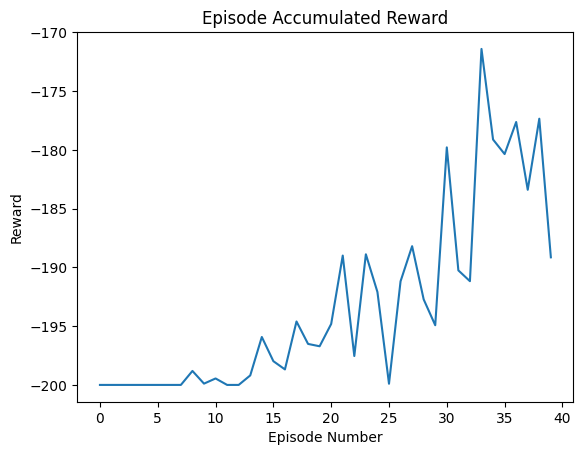

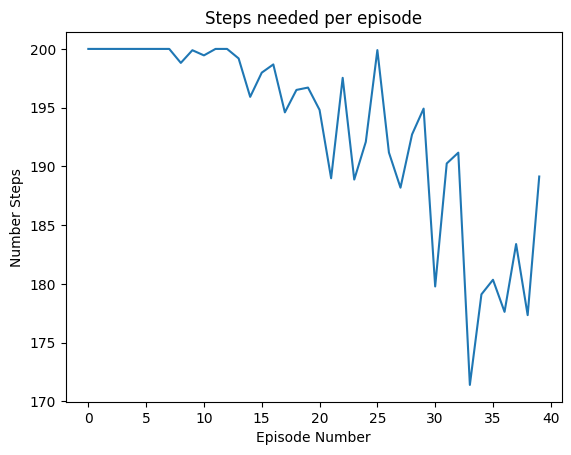

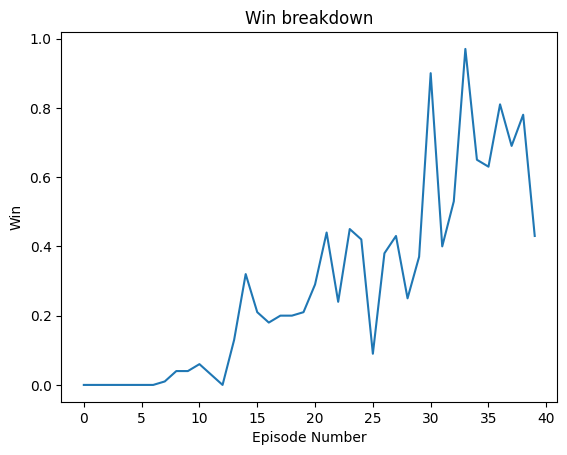

In [ ]:
import matplotlib.pyplot as plt

# Promediamos cada N episodios para ver los resultados mas claramente.
average_range = 100
episode_ticks = int(NUMBER_EPISODES / average_range)

avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

avg_steps = np.array(steps).reshape((episode_ticks, average_range))
avg_steps = np.mean(avg_steps, axis=1)

avg_wins = np.array(wins).reshape((episode_ticks, average_range))
avg_wins = np.mean(avg_wins, axis=1)

# Graficamos

plt.plot(range(episode_ticks), avg_rewards)
plt.title("Episode Accumulated Reward")
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.show()


plt.plot(range(episode_ticks), avg_steps)
plt.title("Steps needed per episode")
plt.xlabel("Episode Number")
plt.ylabel("Number Steps")
plt.show()


plt.plot(range(episode_ticks), avg_wins)
plt.title("Win breakdown")
plt.xlabel("Episode Number")
plt.ylabel("Win")
plt.show()

## Visualizacion del agente

Vamos a ejecutar una política completamente greedy para observar lo aprendido por el algoritmo, usando la q_table retornada por el mismo para decidir la mejor accion.


In [ ]:
env = wrap_env(gym.make("MountainCar-v0"))

observation = env.reset()
position, velocity = discretization(env, observation)

while True:
    env.render()

    action = np.argmax(q_table[position][velocity])
    observation, reward, done, info = env.step(action) 
    
    position, velocity = discretization(env, observation)

    if done:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env

### DynaQ

Recordamos aquí el algoritmo:

<img src="https://i.imgur.com/SIv5K5C.png" alt="Drawing" style="width: 800px;"/>

In [ ]:
import random

def tabular_dynaq(env, number_episodes=100, planning_n=5, alpha=0.1, gamma=0.9, epsilon_start=0.9, epsilon_min=0.1, epsilon_decay=0.9):

  # Initialize Q_table and Model
  q_table = np.zeros((NUMBER_STATES, NUMBER_STATES, env.action_space.n))
  model = {}
  
  # Initialize epsilon
  epsilon = epsilon_start
  
  # Stat trackers
  episode_rewards = []
  episode_steps = []
  wins = []
  

  for ep_idx in range(number_episodes):

    current_reward = 0
    current_steps = 0

    observation = env.reset()
    position, velocity = discretization(env, observation)

    done = False
    while not done:

      # Epsilon greedy.
      action = np.argmax(q_table[position][velocity])
      if np.random.uniform() < epsilon:
        action = np.random.choice(env.action_space.n)
      
      # Take action on env and observe result.
      observation, reward, done, _ = env.step(action)
      new_position, new_velocity = discretization(env, observation)
      current_reward += reward

      # Update rule.
      q_table[position][velocity][action] += alpha * (reward + gamma * np.max(q_table[new_position][new_velocity]) - q_table[position][velocity][action])
      # Add Observation to Model
        
      model[((new_position, new_velocity), action)]= (reward,(new_position, new_velocity))
      # Planning
      for i in range(planning_n):
        #Choose a previously observed State and Action
        ((model_position, model_velocity), model_action) = random.choice(list(model.keys()))
        #Get the Reward and Next State fot that pair State,Action
        (model_reward, (model_new_position, model_new_velocity)) = model[((model_position, model_velocity), model_action)]
        #Update the Q Table with that info
        q_table[model_position][model_velocity][model_action] += alpha * (reward + gamma * np.max(q_table[model_new_position][model_new_velocity]) - q_table[model_position][model_velocity][model_action])

      # Move the state forward.
        position = new_position
        velocity = new_velocity
        current_steps += 1
   
    # Hack to count number of "wins" for mountain car env.
    if position >= 36:
      wins.append(1)
    else:
      wins.append(0)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(current_reward)
    episode_steps.append(current_steps)

  return q_table, episode_rewards, episode_steps, wins


In [ ]:
env = gym.make("MountainCar-v0")
NUMBER_EPISODES = 4000
q_table, rewards, steps, wins = tabular_dynaq(env, number_episodes=NUMBER_EPISODES, planning_n=3, alpha=0.1, epsilon_decay=0.7)

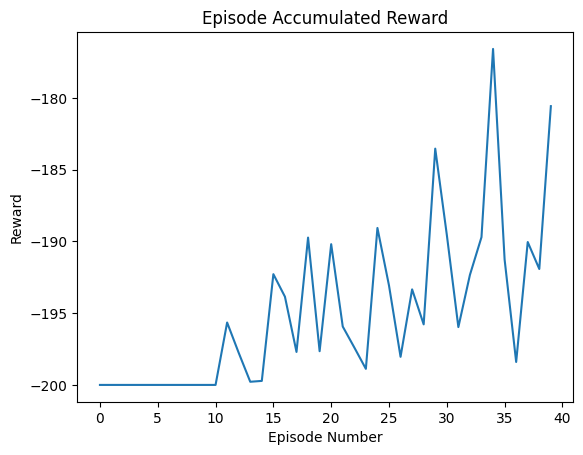

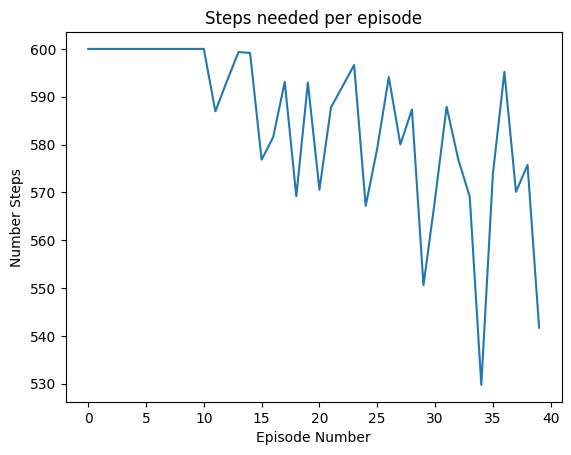

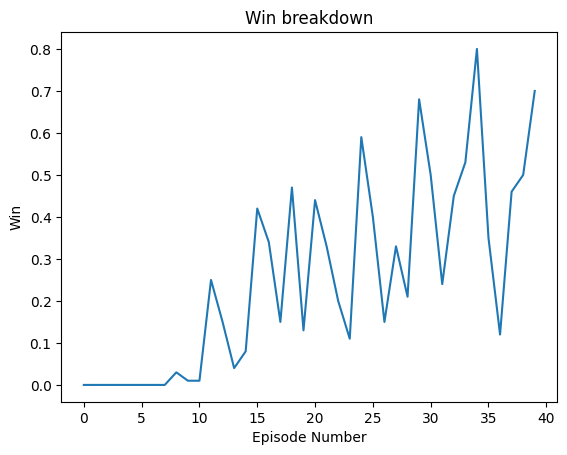

In [ ]:
import matplotlib.pyplot as plt

# Promediamos cada N episodios para ver los resultados mas claramente.
average_range = 100
episode_ticks = int(NUMBER_EPISODES / average_range)

avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

avg_steps = np.array(steps).reshape((episode_ticks, average_range))
avg_steps = np.mean(avg_steps, axis=1)

avg_wins = np.array(wins).reshape((episode_ticks, average_range))
avg_wins = np.mean(avg_wins, axis=1)

# Graficamos

plt.plot(range(episode_ticks), avg_rewards)
plt.title("Episode Accumulated Reward")
plt.xlabel("Episode Number")
plt.ylabel("Reward")
plt.show()


plt.plot(range(episode_ticks), avg_steps)
plt.title("Steps needed per episode")
plt.xlabel("Episode Number")
plt.ylabel("Number Steps")
plt.show()


plt.plot(range(episode_ticks), avg_wins)
plt.title("Win breakdown")
plt.xlabel("Episode Number")
plt.ylabel("Win")
plt.show()

In [ ]:
env = wrap_env(gym.make("MountainCar-v0"))

observation = env.reset()
position, velocity = discretization(env, observation)

while True:
    env.render()

    action = np.argmax(q_table[position][velocity])
    observation, reward, done, info = env.step(action) 
    
    position, velocity = discretization(env, observation)

    if done:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env